In [7]:
import sys
import sklearn
from sklearn import metrics
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import torch
import torchvision
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

In [8]:
# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True)

# Access features and labels
x_train = train_dataset.data.numpy()
y_train = train_dataset.targets.numpy()

x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 28, 28)
Training Labels: (60000,)


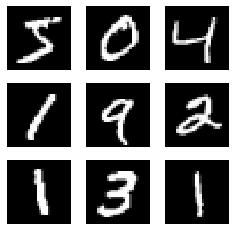

In [10]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (4, 4))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    #ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [11]:
# Increase dimensions by 4 times in x and y directions
x_train = np.repeat(np.repeat(x_train, 4, axis=1), 4, axis=2)
x_test = np.repeat(np.repeat(x_test, 4, axis=1), 4, axis=2)

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Training Data: (60000, 112, 112)
Training Labels: (60000,)


In [12]:
# python magic function
%matplotlib inline

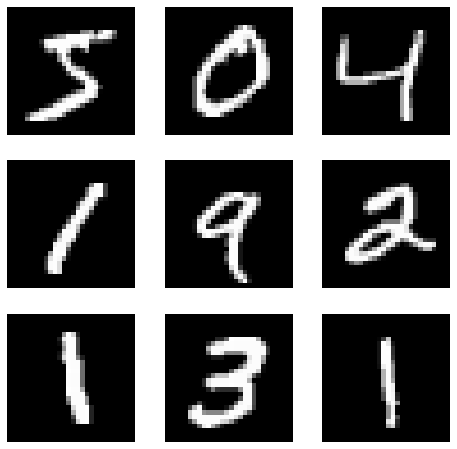

In [13]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig, axs = plt.subplots(3, 3, figsize = (8, 8))
plt.gray()

# loop through subplots and add mnist images
for i, ax in enumerate(axs.flat):
    ax.matshow(x_train[i])
    ax.axis('off')
    #ax.set_title('Number {}'.format(y_train[i]))
    
# display the figure
fig.show()

In [6]:
# preprocessing the images

# convert each image to 1 dimensional array
X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

# normalize the data to 0 - 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.

In [7]:
n_digits = len(np.unique(y_test))
print(n_digits)

# Initialize KMeans model
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Fit the model to the training data
kmeans.fit(X_train)

10


MiniBatchKMeans(n_clusters=10)

In [8]:
X_train.shape

(60000, 12544)

In [27]:
kmeans.labels_

array([16, 27,  4, ..., 24, 34, 22], dtype=int32)

In [10]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    returns: dictionary of clusters assigned to each label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])

        # determine most common label
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]

        #print(labels)
        #print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:
                predicted_labels[i] = key
                
    return predicted_labels

In [11]:
# test the infer_cluster_labels() and infer_data_labels() functions
cluster_labels = infer_cluster_labels(kmeans, y_train)
train_clusters = kmeans.predict(X_train)
predicted_labels = infer_data_labels(train_clusters, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])

[2 0 4 1 4 4 1 2 1 4 2 1 3 6 1 7 2 1 6 7]
[5 0 4 1 9 2 1 3 1 4 3 5 3 6 1 7 2 8 6 9]


In [12]:
def calculate_metrics(estimator, data, labels):

    # Calculate and print metrics
    print('Number of Clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels, estimator.labels_)))

In [13]:
clusters = [10, 16, 36, 64, 144, 256]

# test different numbers of clusters
for n_clusters in clusters:
    estimator = MiniBatchKMeans(n_clusters = n_clusters)
    estimator.fit(X_train)
    
    # print cluster metrics
    calculate_metrics(estimator, X_train, y_train)
    
    # determine predicted labels
    cluster_labels = infer_cluster_labels(estimator, y_train)
    predicted_Y = infer_data_labels(estimator.labels_, cluster_labels)
    
    # calculate and print accuracy
    print('Accuracy: {}\n'.format(metrics.accuracy_score(y_train, predicted_Y)))

Number of Clusters: 10
Inertia: 38118588.08000738
Homogeneity: 0.4545702502127683
Accuracy: 0.5435166666666666

Number of Clusters: 16
Inertia: 35397763.890743986
Homogeneity: 0.5474474545032414
Accuracy: 0.63375

Number of Clusters: 36
Inertia: 31264579.965258375
Homogeneity: 0.6785494758913242
Accuracy: 0.7607333333333334

Number of Clusters: 64
Inertia: 28893171.22951524
Homogeneity: 0.7440250347236814
Accuracy: 0.8192666666666667

Number of Clusters: 144
Inertia: 25943791.231768377
Homogeneity: 0.810562208591361
Accuracy: 0.8744833333333333

Number of Clusters: 256
Inertia: 24084261.61812649
Homogeneity: 0.8426946326736072
Accuracy: 0.8956833333333334



In [14]:
# test kmeans algorithm on testing dataset
# initialize and fit KMeans algorithm on training data
kmeans = MiniBatchKMeans(n_clusters = 256)
kmeans.fit(X_train)
cluster_labels = infer_cluster_labels(kmeans, y_train)

# predict labels for testing data
test_clusters = kmeans.predict(X_test)
predicted_labels = infer_data_labels(kmeans.predict(X_test), cluster_labels)
    
# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

Accuracy: 0.9057



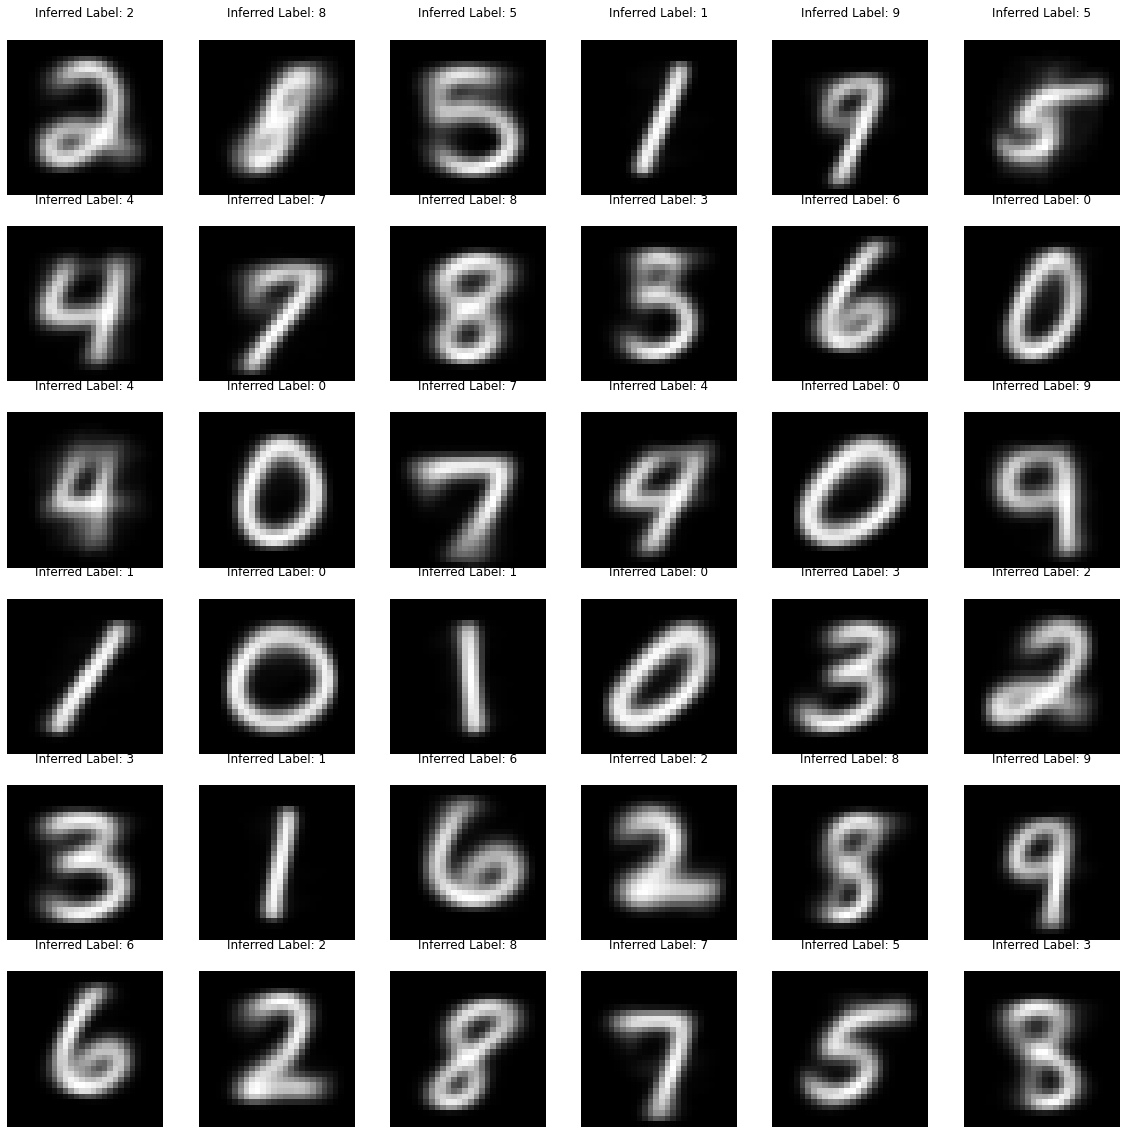

In [15]:
# Initialize and fit KMeans algorithm for training set
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X_train)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 112, 112)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y_train)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

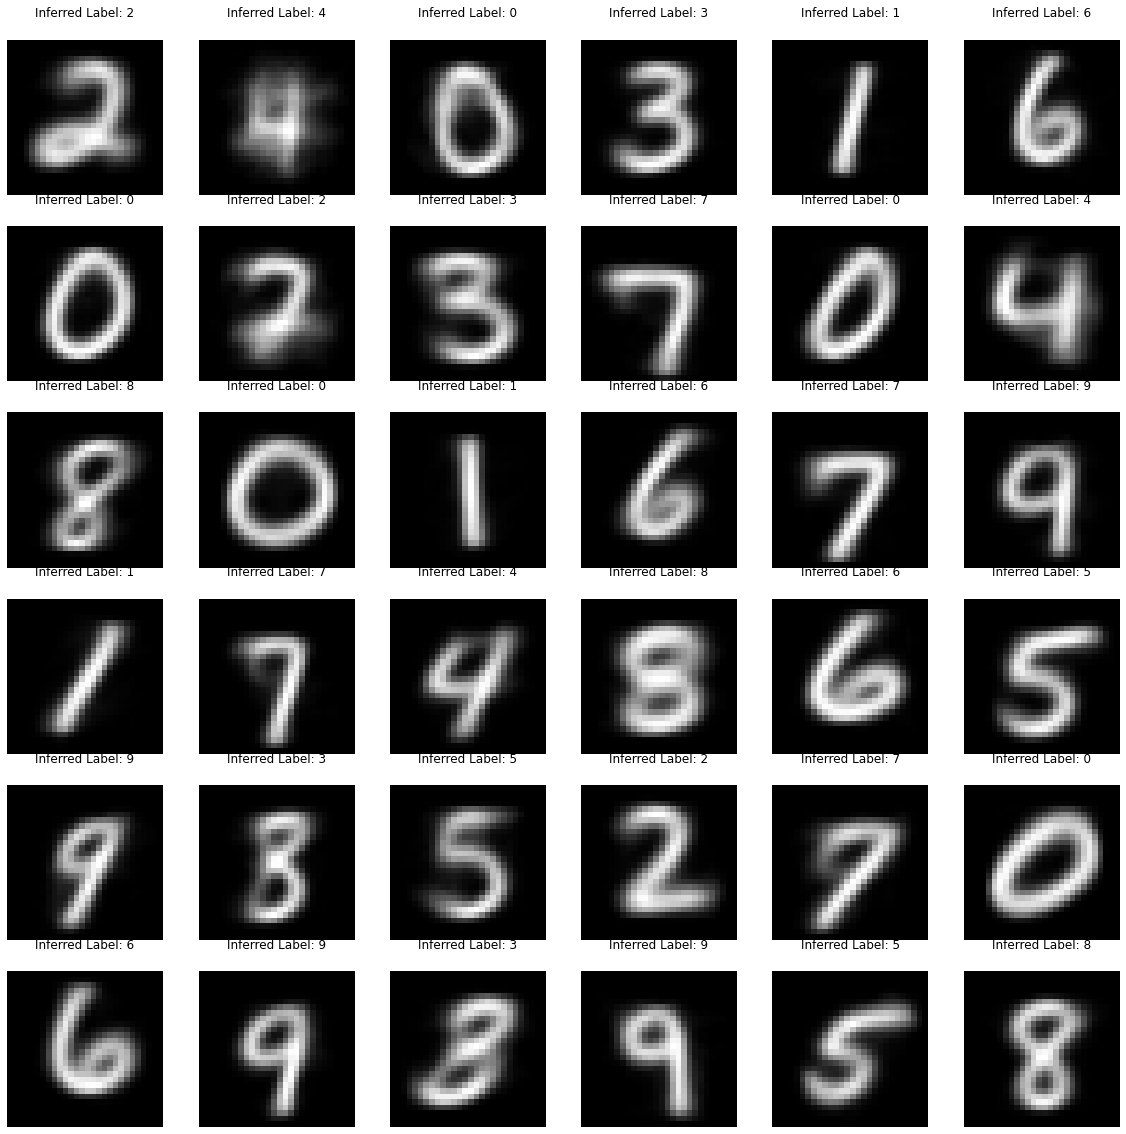

In [25]:
# Initialize and fit KMeans algorithm for test set
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X_test)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 112, 112)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, y_test)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    
# display the figure
fig.show()

In [23]:
cluster_labels.items()

dict_items([(5, [0, 10, 30, 34]), (9, [1, 9, 18, 35]), (1, [2, 7, 13]), (3, [3, 6, 20, 21, 27]), (6, [4, 17, 24, 29]), (0, [5, 12, 14, 26, 31]), (4, [8, 11, 28]), (7, [15, 22, 23]), (2, [16, 25, 32]), (8, [19, 33])])

In [18]:
cluster_labels

{3: [0, 8, 10, 18],
 9: [1, 5, 15, 35],
 1: [2, 22, 25, 28],
 0: [3, 9, 19, 21],
 6: [4, 6, 24, 29],
 2: [7, 26, 30, 31],
 8: [11, 17, 32],
 7: [12, 27, 33, 34],
 4: [13, 14, 20],
 5: [16, 23]}

In [19]:
# Evaluate clustering performance using Adjusted Rand Index (ARI)
ari_train = adjusted_rand_score(y_train, train_clusters)
ari_test = adjusted_rand_score(y_test, test_clusters)
print(f"Adjusted Rand Index (ARI) - Training Set: {ari_train}")
print(f"Adjusted Rand Index (ARI) - Test Set: {ari_test}")

Adjusted Rand Index (ARI) - Training Set: 0.3213040346611774
Adjusted Rand Index (ARI) - Test Set: 0.06759896061083588
